# Fellowship.ai Challenge #
### Predicting Terror ###

Global Terrorism Database (GTD) is an open-source database including information on terrorist events around the world from 1970 through 2014. Some portion of the attacks have not been attributed to a particular terrorist group.

Use attack type, weapons used, description of the attack, etc. to build a model that can predict what group may have been responsible for an incident. 

#### 1. Dependencies ####

In [7]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians,asin
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
import gc
from time import time

%matplotlib inline
plt.style.use('seaborn-whitegrid')

#### 2. Upload Data and Data Exploration ####

In [8]:
# Upload dataframe. Data source: https://www.start.umd.edu/gtd/
# For a detailed description of the featurespace of the dataset, see: https://www.start.umd.edu/gtd/downloads/Codebook.pdf
df = pd.read_csv("terrorism.csv", encoding='ISO-8859-1')

/usr/local/Cellar/ipython/7.1.1/libexec/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (5,7,32,34,62,63,64,77,80,91,93,95,97,115,116,122) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [9]:
df.shape

(181691, 136)

In [10]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 150)

We must first explore the featurespace, eliminate / fill missing data, engineer new features if necessary, and scale features that may need to be scaled.

In [11]:
df.head(5)

,Unnamed: 0,eventid,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related
0,0,197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.456792,-69.951164,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,58.0,Dominican Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANO-D,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN
1,1,197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,North America,Federal,Mexico city,19.371887,-99.086624,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",21.0,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23rd of September Communist League,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,Mexico,1.0,800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN
2,2,197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.478598,120.599741,4.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,1,Assassination,NaN,NaN,NaN,NaN,10,Journalists & Media,54.0,Radio Journalist/Staff/Facility,Voice of America,Employee,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,-9,-9,1,1,NaN
3,3,197001000002,1970,1,0,NaN,0,NaN,78,Greece,8,Western Europe,Attica,Athens,37.997490,23.762728,1.0,0,NaN,NaN,1,1,1,0.0,NaN,NaN,0.0,1,0,3,Bombing/Explosion,NaN,NaN,NaN,NaN,7,Government (Diplomatic),46.0,Embassy/Consulate,NaN,U.S. Embassy,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,Explosives,16.0,Unknown Explosive Type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Explosive,NaN,NaN,Na

In [12]:
len(df.gname.unique())

3537

In [13]:
#check null value
print(df.isnull().sum())

Unnamed: 0                 0
eventid                    0
iyear                      0
imonth                     0
iday                       0
approxdate            172452
extended                   0
resolution            179471
country                    0
country_txt                0
region                     0
region_txt                 0
provstate                421
city                     434
latitude                4556
longitude               4557
specificity                6
vicinity                   0
location              126196
summary                66129
crit1                      0
crit2                      0
crit3                      0
doubtterr                  1
alternative           152680
alternative_txt       152680
multiple                   1
success                    0
suicide                    0
attacktype1                0
attacktype1_txt            0
attacktype2           175377
attacktype2_txt       175377
attacktype3           181263
attacktype3_tx

In [14]:
df_copy = df.copy()

A clear problem to address is missing data, and a large feature space relative to the amount of data. To begin, we'll take a subset of features

In [15]:
features = ['iyear', 'attacktype1', 'targtype1', 'targsubtype1', 'weaptype1', 'latitude',
             'longitude', 'natlty1', 'property', 'INT_ANY', 'gname']

In [16]:
df_copy = df_copy[features]

In [17]:
print(df_copy.isnull().sum())

iyear               0
attacktype1         0
targtype1           0
targsubtype1    10373
weaptype1           0
latitude         4556
longitude        4557
natlty1          1559
property            0
INT_ANY             0
gname               0
dtype: int64


In [18]:
# Going to drop NAs 
df_copy = df_copy.dropna(how = "any", axis = "rows")

In [19]:
df_copy.shape

(166503, 11)

In [20]:
known = df_copy[df_copy.gname != 'Unknown']
known.shape

(91350, 11)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122a10ef0>,
      dtype=object)

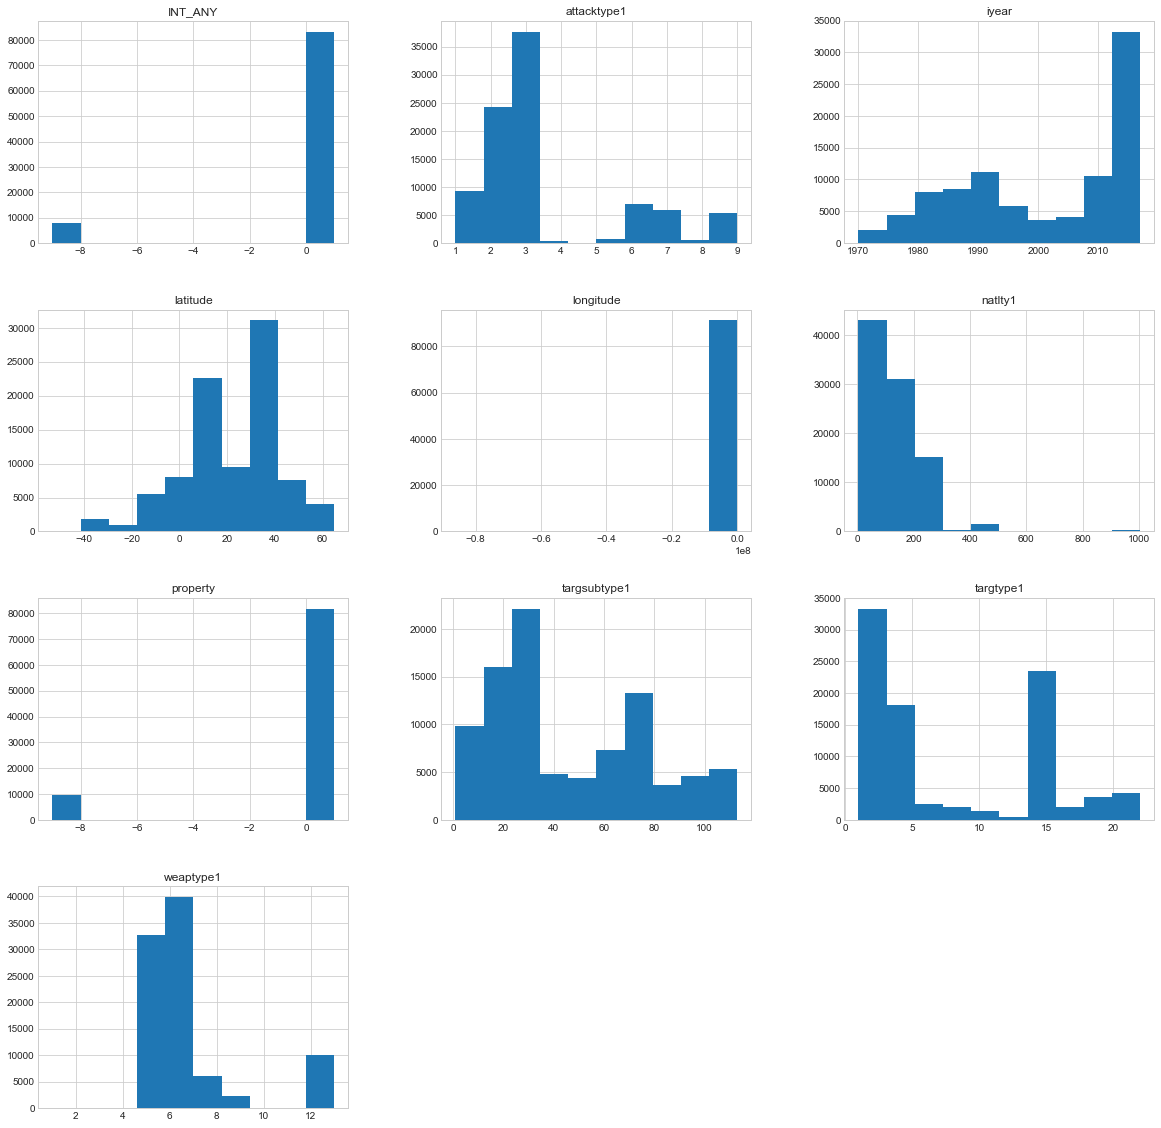

In [21]:
known.hist(figsize=(20,20))

In [22]:
known = known[known['property'] != -9]

In [23]:
known = known[known['INT_ANY'] != -9]

In [24]:
known.shape

(74377, 11)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a6b7550>,
      dtype=object)

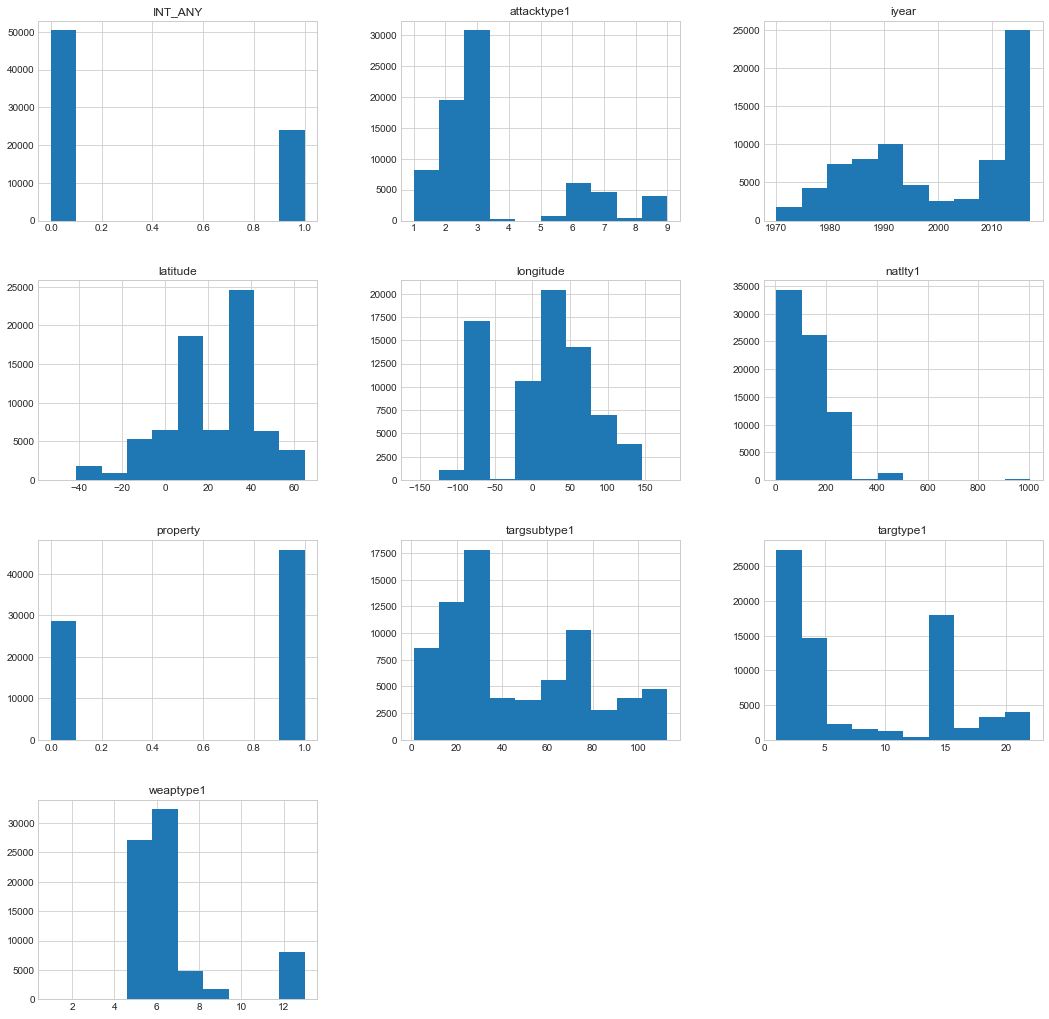

In [25]:
known.hist(figsize=(18,18))

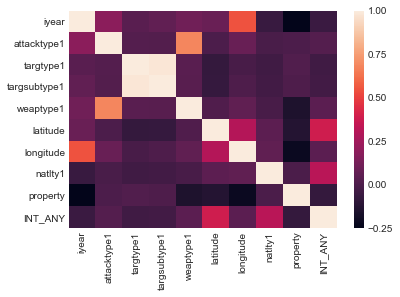

In [26]:
corr = known.corr()
 
# Heatmap
sns.heatmap(corr, fig)

In [27]:
# 'longitude' looks weird
known['longitude'].quantile([0.01, 0.99])

0.01    -91.202541
0.99    125.586191
Name: longitude, dtype: float64

Remove outlier longitude values

In [28]:
known = known[(known['longitude'] > -96.712954) & (known['longitude'] < 125.566599)]

In [29]:
known.shape

(73036, 11)

## Encode ```gname``` as numeric ##

In [30]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(known['gname'])
known['gname'] = le.transform(known['gname'])

### Baseline Model ###

Splitting the data with 'known' values for ```gname``` into training and test sets. Arbitrarily we will select data from 2016 onwards as test data and data from 1970-2015 as training (and validation) data.

In [31]:
train = known[known.iyear < 2016]
test = known[known.iyear >= 2016]

In [32]:
print(train.shape, test.shape)

(62967, 11) (10069, 11)


Split into ```data``` and ```target```: 'gname'

In [33]:
X = train.drop(columns='gname')
y = train.gname

Import packages from sklearn

In [34]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [35]:
# Split into train/validation sets
seed = 42
validation_size = 0.2
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = validation_size, random_state = seed)

In [36]:
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(50373, 10) (12594, 10) (50373,) (12594,)


In [37]:
# Linear Support Vector Classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

/usr/local/lib/python3.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [38]:
y_pred = clf.predict(X_val);

In [39]:
score = accuracy_score(y_val, y_pred)

In [40]:
score

0.79148801016357

In [41]:
X_test = test.drop(columns='gname')
y_test = test.gname

In [42]:
test_pred = clf.predict(X_test);

In [43]:
test_score = accuracy_score(y_test, test_pred)

In [44]:
test_score

0.7924322176978846

## Baseline Results ##

Our model correctly predicts the ```gname``` attribute in the test data ~78.24% of the time.We will now explore possible ways to improve upon this result.

Areas to explore:

* Model selection
* Hyperparameter Tuning
* Feature Importance / SHAP Values

## Model Selection ##

In [45]:
from sklearn.linear_model import LassoCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

In [81]:
# Initialize models
clf_A = LGBMClassifier(random_state=42)
clf_B = GaussianNB()
clf_C = KNeighborsClassifier()

In [82]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # TODO: Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # TODO: Calculate the training time
    results['train_time'] = end - start
        
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train)
    end = time() # Get end time
    
    # TODO: Calculate the total prediction time
    results['pred_time'] = start - end
            
    results['acc_train'] = accuracy_score(y_train, predictions_train)
        
    # TODO: Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

In [83]:
samples_100 = len(y_train)
samples_50 = int(len(y_train) * 0.5) # 'int' not 'float'
samples_10 = int(len(y_train) * 0.1) # 'int' not 'float'

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_10, samples_50, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_val, y_val)

LGBMClassifier trained on 5037 samples.
LGBMClassifier trained on 25186 samples.
LGBMClassifier trained on 50373 samples.
GaussianNB trained on 5037 samples.
GaussianNB trained on 25186 samples.
GaussianNB trained on 50373 samples.
KNeighborsClassifier trained on 5037 samples.
KNeighborsClassifier trained on 25186 samples.
KNeighborsClassifier trained on 50373 samples.


In [84]:
results

{'LGBMClassifier': {0: {'train_time': 34.51980686187744,
   'pred_time': -56.661803007125854,
   'acc_train': 0.13392094971512516,
   'acc_test': 0.13863744640304906},
  1: {'train_time': 317.7295560836792,
   'pred_time': -103.62668919563293,
   'acc_train': 0.11837690826434796,
   'acc_test': 0.11783388915356519},
  2: {'train_time': 1049.483439207077,
   'pred_time': -117.37152099609375,
   'acc_train': 0.0782363567784329,
   'acc_test': 0.08107035096077497}},
 'GaussianNB': {0: {'train_time': 0.0635519027709961,
   'pred_time': -6.228415012359619,
   'acc_train': 0.5548607388878963,
   'acc_test': 0.5348578688264253},
  1: {'train_time': 0.23502326011657715,
   'pred_time': -16.032865047454834,
   'acc_train': 0.4668572449526532,
   'acc_test': 0.42377322534540257},
  2: {'train_time': 0.49442100524902344,
   'pred_time': -20.93898916244507,
   'acc_train': 0.42699462013380185,
   'acc_test': 0.37486104494203587}},
 'KNeighborsClassifier': {0: {'train_time': 0.012933969497680664,
 

# TO DO #

1. Write up each step of the analysis
2. Description of the various models chosen
3. Permutation Importance and SHAP Values
4. Feature Scaling

KNearestNeighbors performed far better tham LGBMClassifier and Gaussian Naive Bayes. We will continue with KNN.

In [46]:
clf = KNeighborsClassifier()

In [47]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [48]:
y_pred = clf.predict(X_val)

In [49]:
score = accuracy_score(y_pred, y_val)

In [50]:
score

0.7253454025726537

# Explain Predictions with SHAP Values #

In [51]:
import shap
shap.initjs()

In [ ]:
explainer = shap.KernelExplainer(knn.predict_proba, X_train.iloc[0,:])
shap_values = explainer.shap_values(X_val.iloc[0,:])
shap.force_plot(explainer.expected_value[0], shap_values[0], X_val.iloc[0,:])